# Let's Clean the Feature Data

Let's make sure our features are clean. This feature engineering might help the model more accurately predict civil unrest if there's less garbage. 

---

Let's load the feature data

---

In [33]:
import pandas as pd

# Load the feature data
data = pd.read_csv('csv/data.csv')
data

Date  EventCode                            ActionGeo_FullName  \
0     2024-08-23        145           Union Park, Illinois, United States   
1     2024-08-22        145           Union Park, Illinois, United States   
2     2024-08-20        145           Union Park, Illinois, United States   
3     2024-08-20        145           Union Park, Illinois, United States   
4     2024-06-27        145  Buckingham Fountain, Illinois, United States   
...          ...        ...                                           ...   
3491  2015-01-19        145              Chicago, Illinois, United States   
3492  2015-01-19        145              Chicago, Illinois, United States   
3493  2015-01-19        145              Chicago, Illinois, United States   
3494  2015-01-19        145              Chicago, Illinois, United States   
3495  2015-01-08        145              Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
0           41.8839        -87.6648 -3.046968  
1           41.8839        -87.6648  0.000000  
2           41.8839        -87.6648 -4.319654  
3           41.8839        -87.6648 -4.319654  
4           41.8756        -87.6189 -7.052186  
...             ...             ...       ...  
3491        41.8500        -87.6501  2.494577  
3492        41.8500        -87.6501  2.494577  
3493        41.8500        -87.6501  2.494577  
3494        41.8500        -87.6501  2.857143  
3495        41.8500        -87.6501  2.007772  

[3496 rows x 6 columns]

In [34]:
from sklearn.cluster import MeanShift
import folium
import matplotlib.pyplot as plt

# Extract the relevant features for clustering
X_meanshift = data[['ActionGeo_Lat', 'ActionGeo_Long']]

# Perform Mean Shift Clustering
mean_shift = MeanShift()
mean_shift.fit(X_meanshift)
labels_meanshift = mean_shift.labels_
cluster_centers_meanshift = mean_shift.cluster_centers_

# Add the cluster labels to the dataframe
data['Cluster_MeanShift'] = labels_meanshift

# Create a map centered around the mean location
map_center = [data['ActionGeo_Lat'].mean(), data['ActionGeo_Long'].mean()]
m_meanshift = folium.Map(location=map_center, zoom_start=10)

# Add points to the map
for idx, row in data.iterrows():
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=5,
        color='blue' if row['Cluster_MeanShift'] == 0 else 'green' if row['Cluster_MeanShift'] == 1 else 'purple',
        fill=True,
        fill_color='blue' if row['Cluster_MeanShift'] == 0 else 'green' if row['Cluster_MeanShift'] == 1 else 'purple',
        fill_opacity=0.6
    ).add_to(m_meanshift)

# Add cluster centers to the map
for center in cluster_centers_meanshift:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m_meanshift)

# Display the map
m_meanshift


---

The problem with this clustering technique, is that many of the discrete clusterings are what I would consider to be still Chicago is so large, and I think all of these clusters outside of CA would be relevant.

Instead of toying with the parameters of the clustering techniques, let's just try a different technique to see if it performs better.

---

In [35]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_meanshift)
labels_dbscan = dbscan.labels_
data['Cluster_DBSCAN'] = labels_dbscan

# Create a map centered around the mean location
m_dbscan = folium.Map(location=map_center, zoom_start=4)

# Add points to the map
for idx, row in data.iterrows():
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=5,
        color='blue' if row['Cluster_DBSCAN'] == 0 else 'green' if row['Cluster_DBSCAN'] == 1 else 'purple' if row['Cluster_DBSCAN'] == -1 else 'orange',
        fill=True,
        fill_color='blue' if row['Cluster_DBSCAN'] == 0 else 'green' if row['Cluster_DBSCAN'] == 1 else 'purple' if row['Cluster_DBSCAN'] == -1 else 'orange',
        fill_opacity=0.6
    ).add_to(m_dbscan)

# Group by the DBSCAN cluster labels and calculate the mean latitude and longitude for each cluster
DBSCAN_cluster_means = data.groupby('Cluster_DBSCAN')[['ActionGeo_Lat', 'ActionGeo_Long']].mean()

# Add cluster centers to the map
for idx, center in DBSCAN_cluster_means.iterrows():
    folium.Marker(
        location=[center['ActionGeo_Lat'], center['ActionGeo_Long']],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m_dbscan)

# Display the map
m_dbscan

---

How many clusters are there?

---

In [36]:
DBSCAN_cluster_means

ActionGeo_Lat  ActionGeo_Long
Cluster_DBSCAN                               
-1                  38.437100      -120.83600
 0                  41.851578       -87.64882

In [37]:
num_clusters_dbscan = len(DBSCAN_cluster_means)
print(f'The number of DBSCAN clusters is: {num_clusters_dbscan}')

The number of DBSCAN clusters is: 2


---

How many members are there in each cluster?

---

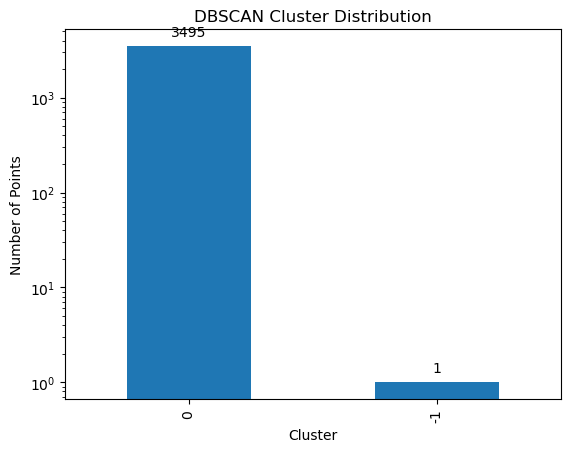

In [38]:
ax = data['Cluster_DBSCAN'].value_counts().plot(kind='bar')
plt.yscale('log')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('DBSCAN Cluster Distribution')

# Add the total of each category to the top of the column as a label
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

---

This is silly! I've been fretting over 1 row this entire time! Well at least this formulation would be more robust, given varying data sets.

---

---

Let's clean this 1 bad row. 

---

In [39]:
# Identify the mode of the Cluster_DBSCAN column
mode_cluster = data['Cluster_DBSCAN'].mode()[0]

# Print the mode cluster
print(f'The mode cluster is: {mode_cluster}')

# Identify the clusters that are not the mode
clusters_to_remove = data['Cluster_DBSCAN'].unique()
clusters_to_remove = clusters_to_remove[clusters_to_remove != mode_cluster]

# Print the clusters that are being removed
print(f'Clusters to be removed: {clusters_to_remove}')

# clean the dataframe to keep only the rows where Cluster_DBSCAN is equal to the mode
cleaned_data = data[data['Cluster_DBSCAN'] == mode_cluster]

# Display the cleaned dataframe
print('Cleaned Data:')
cleaned_data

The mode cluster is: 0
Clusters to be removed: [-1]
Cleaned Data:


Date  EventCode                            ActionGeo_FullName  \
0     2024-08-23        145           Union Park, Illinois, United States   
1     2024-08-22        145           Union Park, Illinois, United States   
2     2024-08-20        145           Union Park, Illinois, United States   
3     2024-08-20        145           Union Park, Illinois, United States   
4     2024-06-27        145  Buckingham Fountain, Illinois, United States   
...          ...        ...                                           ...   
3491  2015-01-19        145              Chicago, Illinois, United States   
3492  2015-01-19        145              Chicago, Illinois, United States   
3493  2015-01-19        145              Chicago, Illinois, United States   
3494  2015-01-19        145              Chicago, Illinois, United States   
3495  2015-01-08        145              Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  Cluster_MeanShift  \
0           41.8839        -87.6648 -3.046968                  4   
1           41.8839        -87.6648  0.000000                  4   
2           41.8839        -87.6648 -4.319654                  4   
3           41.8839        -87.6648 -4.319654                  4   
4           41.8756        -87.6189 -7.052186                  1   
...             ...             ...       ...                ...   
3491        41.8500        -87.6501  2.494577                  0   
3492        41.8500        -87.6501  2.494577                  0   
3493        41.8500        -87.6501  2.494577                  0   
3494        41.8500        -87.6501  2.857143                  0   
3495        41.8500        -87.6501  2.007772                  0   

      Cluster_DBSCAN  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3491               0  
3492               0  
3493               0  
3494               0  
3495               0  

[3495 rows x 8 columns]

---

Ok let's update our data source with our new cleaned feature data.

---

In [40]:
cleaned_data = cleaned_data.drop(columns=['Cluster_MeanShift', 'Cluster_DBSCAN'])
cleaned_data.to_csv('csv/data_cleaned.csv', index=False)